In [1]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

In [2]:
%matplotlib notebook

In [3]:
# calibration of the voltage - position conversion
def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [4]:
# load the data
Year = "2020"
Month = "08"
Day = "09"
BeadNumber = 1
#RunNumber = 144
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/Bead"+str(BeadNumber)+"/Shaking/"
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/Bead"+str(BeadNumber)+"/BeamProfile/"

files = load_dir(folder, file_prefix = 'BeamProfileX1', max_file=500)

91  files in folder
91  files loaded


In [5]:
from scipy.optimize import curve_fit
from scipy.stats import norm

In [6]:
def get_waist(pos,pd, flip=False):

    pos1 = voltage_to_position(pos)
    if (flip):
        pos1 *= -1
    data1 = np.array(pd)-np.min(pd)
    data1 = data1/np.max(data1)    
    #noraml CDF fit
    temp_params = curve_fit(norm.cdf, pos1, data1, p0=[pos1[2500],5])[0]
    
    if (flip):
        temp_params[0] *= -1
    return temp_params

In [7]:
a=[1,2,3,4,5,6,7,8,9,0]
ave=np.average(a[0:4])
print(ave)

2.5


In [9]:
parX1 = []
parX2 = []
for ff in files:
    pos_x = ff.cant_pos[0]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data
    spin=np.zeros(5000)
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parX1.append(get_waist(pos_x, quad_sum, flip=True))
    parX2.append(get_waist(pos_x, spin))
parX1 = np.array(parX1)
parX2 = np.array(parX2)
ZrangeX = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

In [10]:
def beamwidth_fun(t,z,w):
    return w*np.sqrt(1+((t-z)/np.pi/w/w*1.064)**2)

Zrange = np.linspace(5,95,101)

def fit_waist(pars):
    return curve_fit(beamwidth_fun, Zrange, pars[:,1],p0=[50,5])[0]

In [11]:
print(parX2[:,1])

[2.54000287 2.65087291 2.71235385 2.83409639 2.83875899 2.88472626
 2.92081464 3.04615706 3.10795581 3.20056351 3.21531165 3.26313366
 3.35729204 3.4592448  3.50522703 3.60711514 3.66541238 3.7715697
 3.88252366 3.90431642 4.04441923 4.0547787  4.06763194 4.30216914
 4.27322291 4.45882032 4.55636448 4.60705979 4.70546923 4.79239236
 4.96937608 4.9028982  5.06376361 5.29714431 5.16805663 5.26073326
 5.28218026 5.52347487 5.45047557 5.65638869 5.66711683 5.83536439
 5.87868941 6.00868704 6.17809208 6.21233361 6.22211268 6.38678128
 6.54736085 6.58192111 6.64756467 6.79106275 6.7881217  6.73045279
 7.03656029 6.90755952 7.17908048 7.09292687 7.24461531 7.40549998
 7.43673003 7.50213146 7.53189644 7.67837786 7.71114612 7.88400306
 7.88747396 8.0692424  8.04904457 8.31505518 8.33418782 8.38931671
 8.42262229 8.51833267 8.5034228  8.71156405 8.81285836 8.75666161
 8.93021654 9.04683362 9.11307815 9.32434024 9.16340245 9.22547251
 9.3278457  9.44817125 9.44454301 9.53530952 9.60352521 9.60410

In [12]:
pfitX1 = fit_waist(parX1)
pfitX2 = fit_waist(parX2)
print(pfitX2), print(pfitX1)

ValueError: operands could not be broadcast together with shapes (101,) (91,) 

<IPython.core.display.Javascript object>


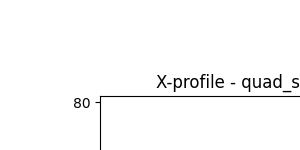

In [13]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeX,parX1[:,1]*2)
#ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitX1),'r--')
ax[0,0].set(title='X-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeX,parX2[:,1]*2)
#ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitX2),'r--')
ax[0,1].set(title='X-profile - spin_data')

ax[1,0].scatter(ZrangeX,parX1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeX,parX2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')
ofname = folder+"/BeamProfile4_Plot.png" 

plt.savefig(ofname,dpi=300)

In [14]:
## plot y direction

In [14]:
# load the data
Year = "2020"
Month = "06"
Day = "05"
BeadNumber = 1
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/Bead"+str(BeadNumber)+"/Shaking/"
#folder = r'/data/new_trap/20200222/NoBead/X_Shaking/'
#folder = r'/data/new_trap/20200210/Bead2/Shaking/'
#folder = r'/data/new_trap/20200507/NoBead/Shaking/'
# files = load_dir(folder, file_prefix = 'Shaking3', max_file=500)
# filesY = load_dir(folder, file_prefix = 'BeamProfiling', max_file=500)
files = load_dir(folder, file_prefix = 'BeamProfileY', max_file=500)

1  files in folder
1  files loaded


In [15]:
parY1 = []
parY2 = []
for ff in files:
    pos_y = ff.cant_pos[1]
    quad_sum = ff.quad_sum
    spin = ff.spin_data
    parY1.append(get_waist(pos_y, quad_sum))
    parY2.append(get_waist(pos_y, spin, flip=True))
parY1 = np.array(parY1)
parY2 = np.array(parY2)
ZrangeY = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

In [16]:
def beamwidth_fun(t,z,w):
    return w*np.sqrt(1+((t-z)/np.pi/w/w*1.064)**2)

Zrange = np.linspace(5,95,101)

def fit_waist(pars):
    return curve_fit(beamwidth_fun, Zrange, pars[:,1],p0=[50,5])[0]

In [17]:
print(parY2[:,1])

[1.91777927]


<IPython.core.display.Javascript object>


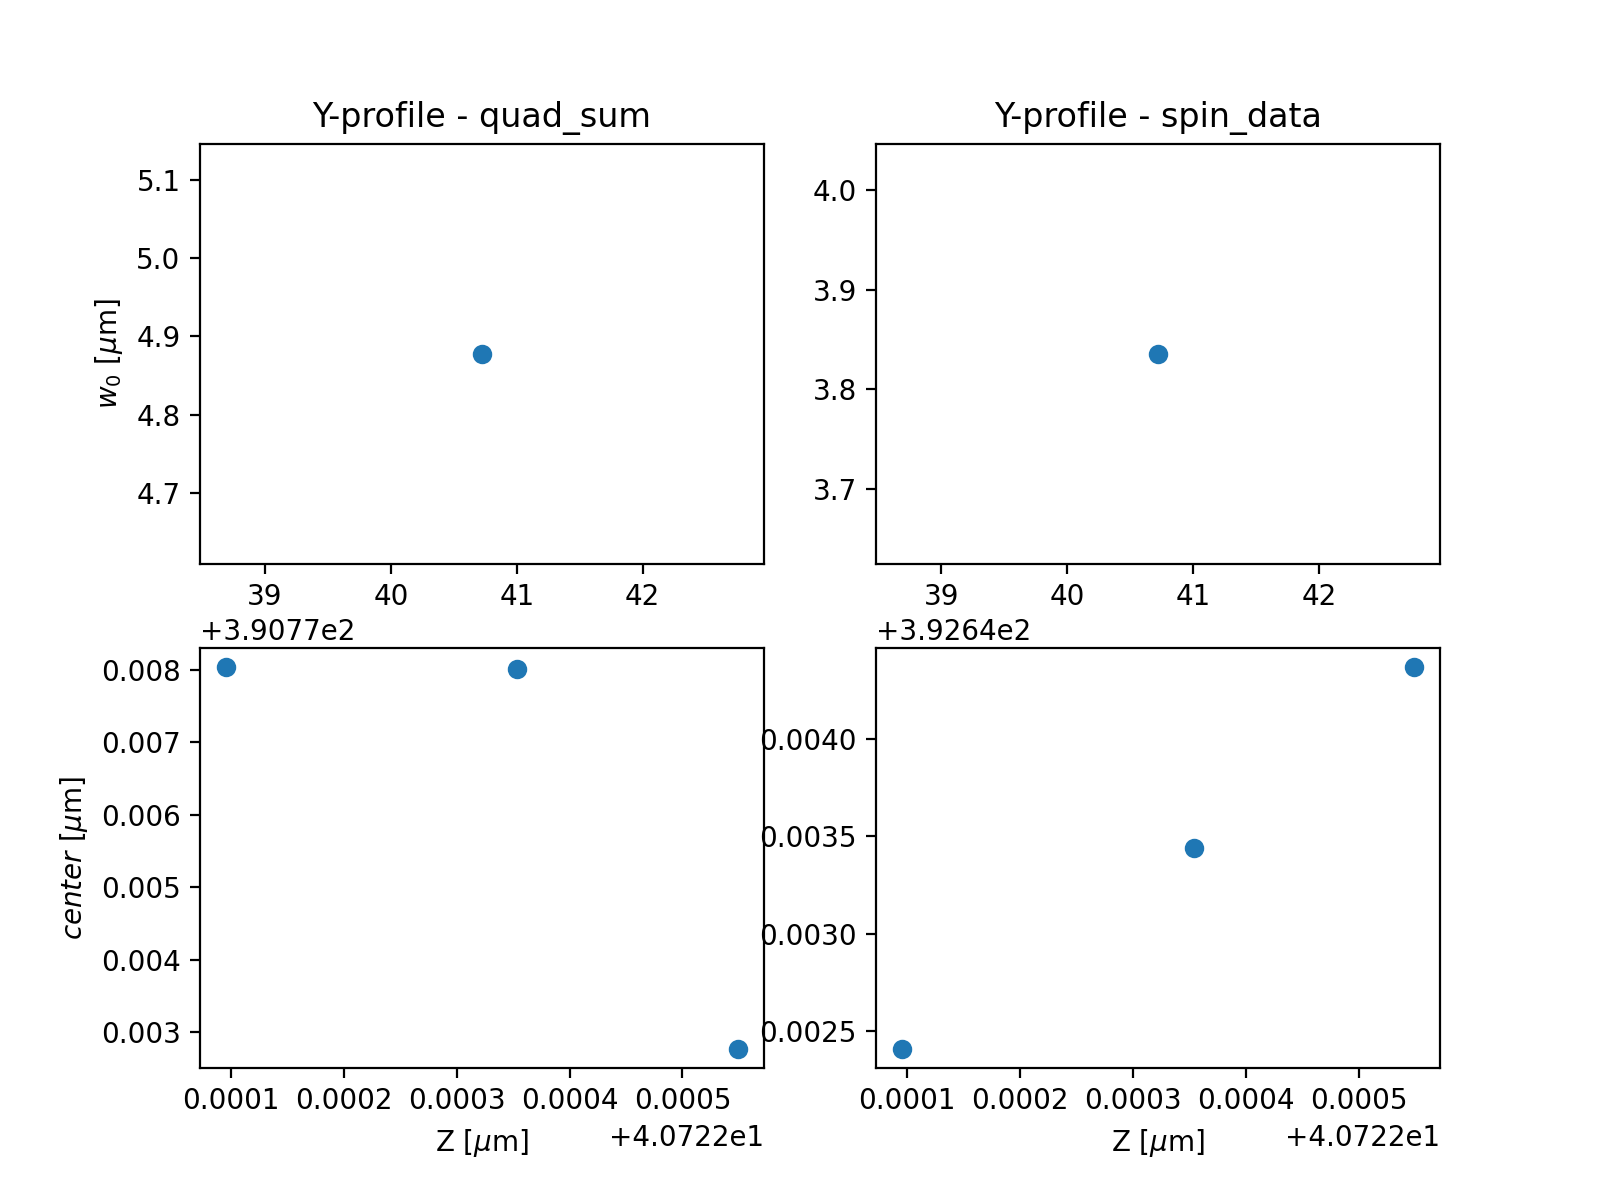

In [18]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeY,parY1[:,1]*2)
#ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitX1),'r--')
ax[0,0].set(title='Y-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeY,parY2[:,1]*2)
#ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitX2),'r--')
ax[0,1].set(title='Y-profile - spin_data')

ax[1,0].scatter(ZrangeX,parX1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeX,parX2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')
ofname = folder+"/BeamProfile5_Plot.png" 

plt.savefig(ofname,dpi=300)